## Load Dataset


Load the 'EastWestAirlines.xlsx' dataset into a pandas DataFrame and perform an initial inspection of its structure and content.


In [8]:
import pandas as pd

# Load the 'data' sheet from the Excel file into a DataFrame, assuming the header is on the first row (index 0)
df = pd.read_excel('/content/EastWestAirlines.xlsx', sheet_name='data', header=0)

# Display the first 5 rows of the DataFrame
print('First 5 rows of the DataFrame after loading the "data" sheet:')
print(df.head())
print('\n')

# Print a concise summary of the DataFrame
print('DataFrame Info after loading the "data" sheet:')
df.info()
print('\n')

# Generate descriptive statistics of the DataFrame\'s numerical columns
print('Descriptive Statistics after loading the "data" sheet:')
print(df.describe())
print('\n')

# Print the shape of the DataFrame
print('Shape of the DataFrame (rows, columns) after loading the "data" sheet:')
print(df.shape)

First 5 rows of the DataFrame after loading the "data" sheet:
   ID#  Balance  Qual_miles  cc1_miles  cc2_miles  cc3_miles  Bonus_miles  \
0    1    28143           0          1          1          1          174   
1    2    19244           0          1          1          1          215   
2    3    41354           0          1          1          1         4123   
3    4    14776           0          1          1          1          500   
4    5    97752           0          4          1          1        43300   

   Bonus_trans  Flight_miles_12mo  Flight_trans_12  Days_since_enroll  Award?  
0            1                  0                0               7000       0  
1            2                  0                0               6968       0  
2            4                  0                0               7034       0  
3            1                  0                0               6952       0  
4           26               2077                4               6935      

## Data Preprocessing


Preprocess the dataset by handling missing values (if any), identifying and addressing outliers, and scaling numerical features to prepare the data for clustering algorithms.


### Handling Missing Values

As observed from the `df.info()` output in the previous step, all columns have 3999 non-null entries, which is equal to the total number of rows in the DataFrame. This confirms that there are no missing values in the dataset, so no imputation or removal strategy is required at this stage.


Following the instructions, the next step is to identify outliers in the numerical columns. Visualizing them using box plots is an effective way to identify their presence and distribution.



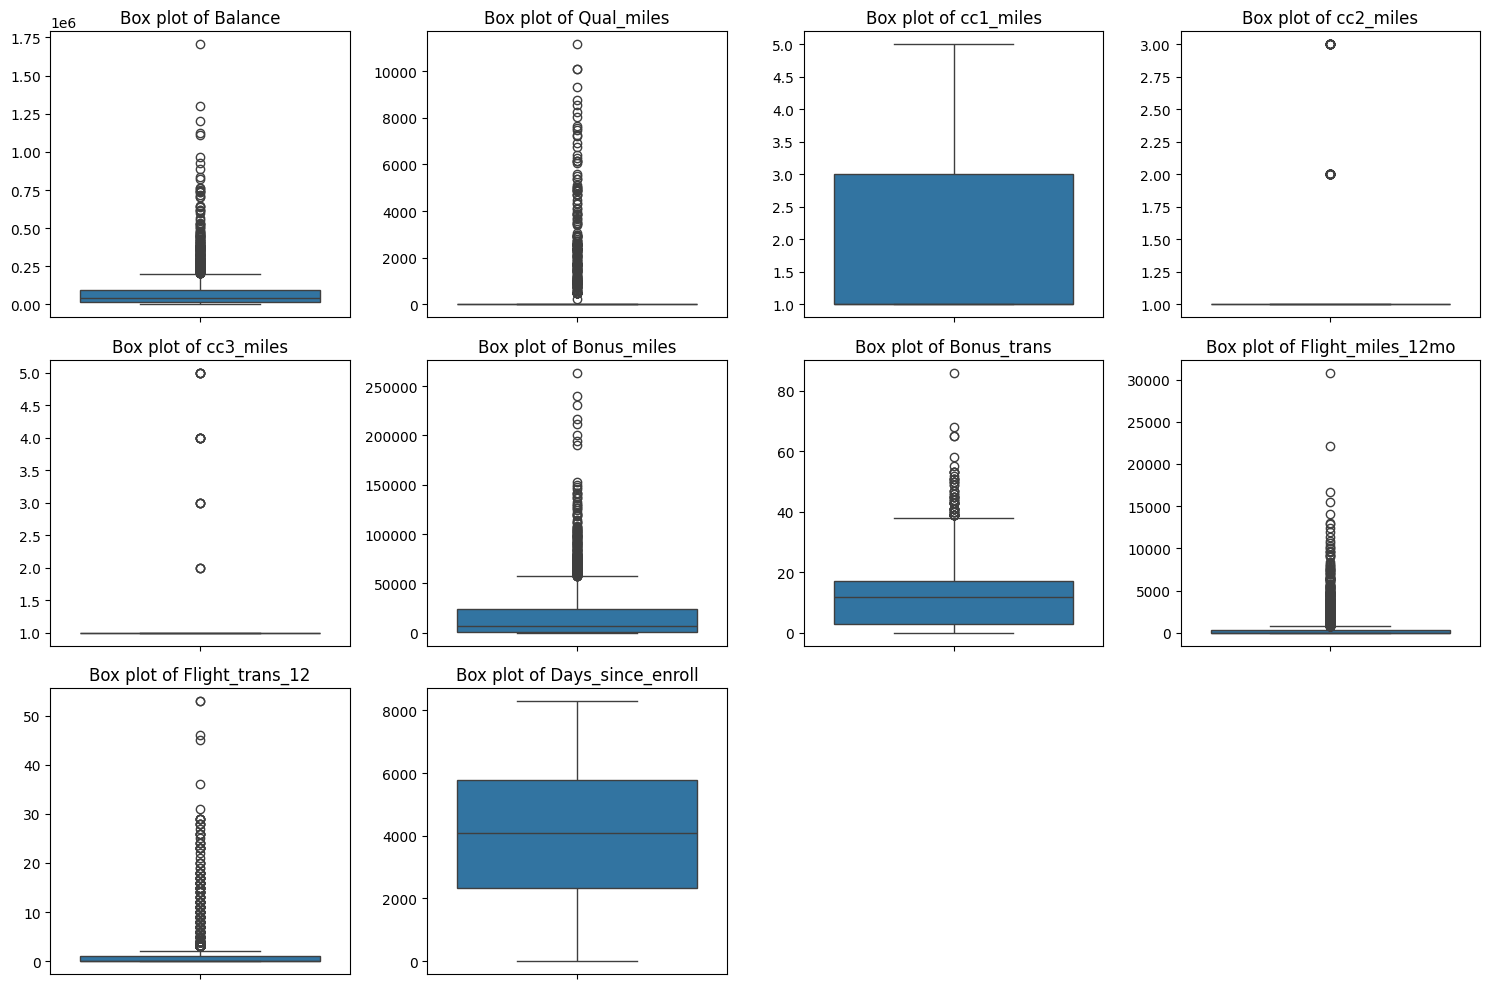

Box plots generated for numerical columns to identify outliers.


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get numerical columns (excluding 'ID#' which is an identifier and 'Award?' which is a binary target)
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('ID#')
numerical_cols.remove('Award?')

# Set up the matplotlib figure layout for box plots
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 4, i)  # Adjust subplot grid based on number of columns
    sns.boxplot(y=df[col])
    plt.title(f'Box plot of {col}')
    plt.ylabel('') # Remove y-label to avoid clutter
plt.tight_layout()
plt.show()

print("Box plots generated for numerical columns to identify outliers.")


The box plots generated in the previous step indicate the presence of significant outliers in several numerical columns. To mitigate their impact on clustering algorithms, I will define a strategy to address these outliers by capping them using the Interquartile Range (IQR) method. This approach will replace values beyond the upper and lower whiskers with the respective cap values, preventing extreme values from skewing the clustering results without removing data points.



Outliers capped for numerical columns using IQR method.

Descriptive Statistics after outlier capping:
             Balance  Qual_miles    cc1_miles  cc2_miles  cc3_miles  \
count    3999.000000      3999.0  3999.000000     3999.0     3999.0   
mean    63768.635784         0.0     2.059515        1.0        1.0   
std     58673.700736         0.0     1.376919        0.0        0.0   
min         0.000000         0.0     1.000000        1.0        1.0   
25%     18527.500000         0.0     1.000000        1.0        1.0   
50%     43097.000000         0.0     1.000000        1.0        1.0   
75%     92404.000000         0.0     3.000000        1.0        1.0   
max    203218.750000         0.0     5.000000        1.0        1.0   

        Bonus_miles  Bonus_trans  Flight_miles_12mo  Flight_trans_12  \
count   3999.000000  3999.000000        3999.000000      3999.000000   
mean   15410.730683    11.470618         178.055639         0.591523   
std    18074.733482     9.115104         

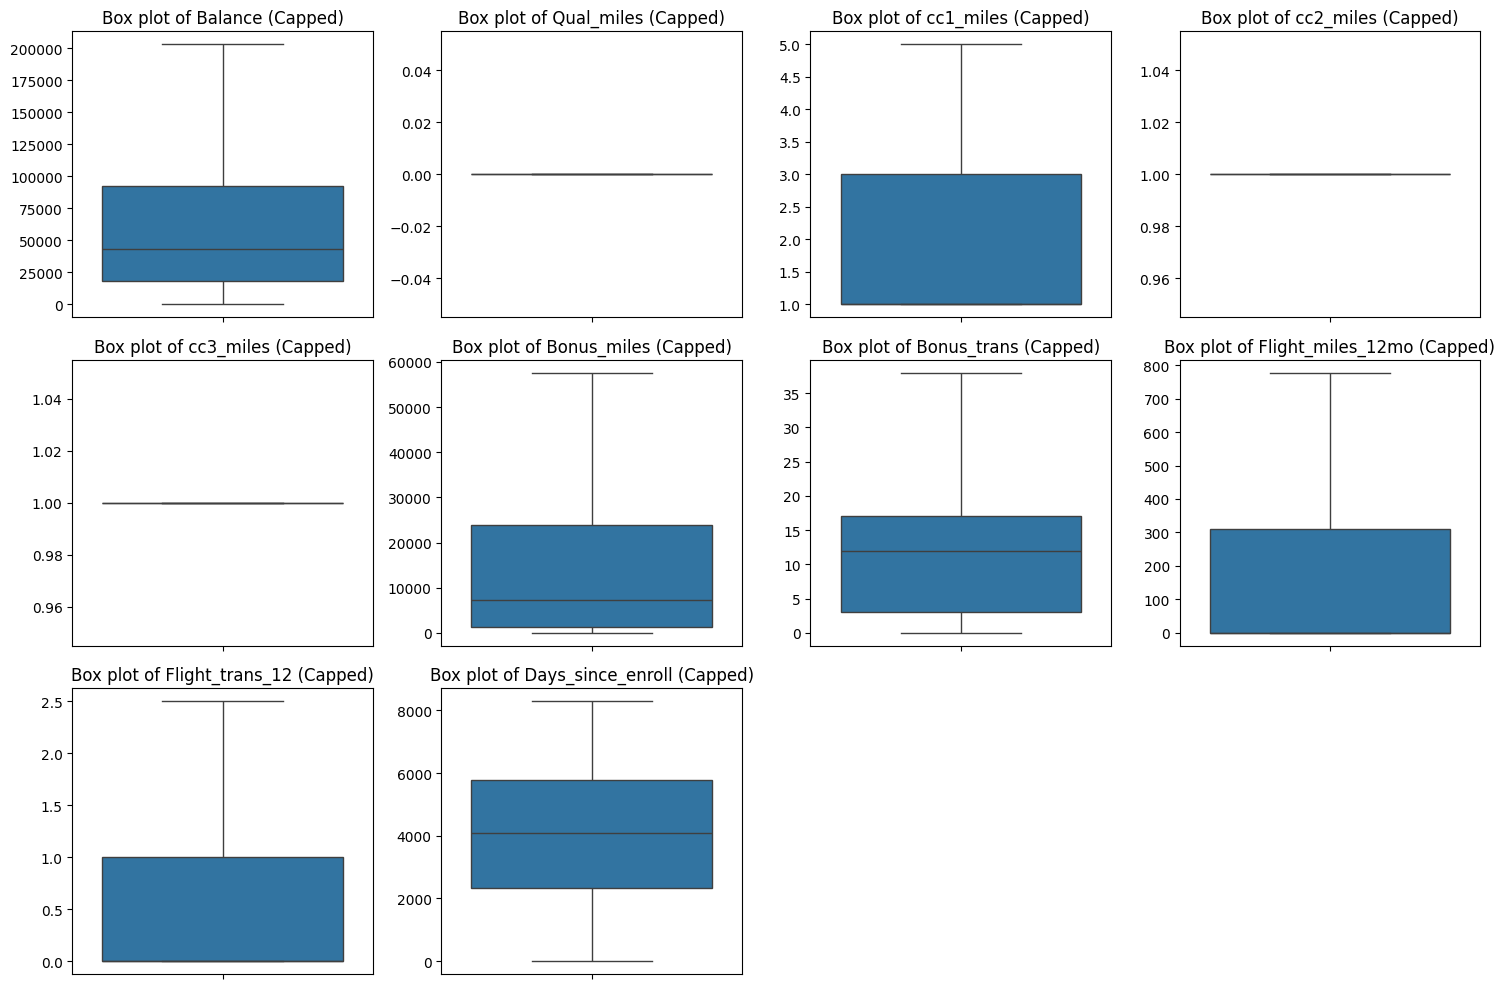

In [10]:
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap outliers
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

print("Outliers capped for numerical columns using IQR method.")

# Display descriptive statistics after capping
print('\nDescriptive Statistics after outlier capping:')
print(df[numerical_cols].describe())

# Re-generate box plots to visualize the effect of capping
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 4, i)  # Adjust subplot grid based on number of columns
    sns.boxplot(y=df[col])
    plt.title(f'Box plot of {col} (Capped)')
    plt.ylabel('') # Remove y-label to avoid clutter
plt.tight_layout()
plt.show()


The next step is to scale the selected numerical features. Since clustering algorithms are sensitive to the scale of features, using `StandardScaler` will normalize the data to have a mean of 0 and a standard deviation of 1, which is a common practice before applying clustering algorithms. The 'ID#' and 'Award?' columns will be excluded from scaling, as 'ID#' is an identifier and 'Award?' is a binary target that doesn't require scaling.



In [11]:
from sklearn.preprocessing import StandardScaler

# Create a copy of the DataFrame for scaling to avoid modifying the original df directly with scaled values
df_scaled = df.copy()

# Select the numerical columns for scaling, excluding 'ID#' and 'Award?'
# 'numerical_cols' was already defined in previous steps and excludes these, so we can use it.

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply scaling to the selected numerical columns
df_scaled[numerical_cols] = scaler.fit_transform(df_scaled[numerical_cols])

print("Numerical features scaled using StandardScaler.")

# Display the first 5 rows of the scaled DataFrame
print('\nFirst 5 rows of the scaled DataFrame:')
print(df_scaled.head())
print('\n')

# Generate descriptive statistics of the scaled numerical columns to verify scaling
print('Descriptive Statistics of scaled numerical columns:')
print(df_scaled[numerical_cols].describe())

Numerical features scaled using StandardScaler.

First 5 rows of the scaled DataFrame:
   ID#   Balance  Qual_miles  cc1_miles  cc2_miles  cc3_miles  Bonus_miles  \
0    1 -0.607258         0.0  -0.769578        0.0        0.0    -0.843091   
1    2 -0.758947         0.0  -0.769578        0.0        0.0    -0.840822   
2    3 -0.382070         0.0  -0.769578        0.0        0.0    -0.624581   
3    4 -0.835106         0.0  -0.769578        0.0        0.0    -0.825052   
4    5  0.579265         0.0   1.409471        0.0        0.0     1.543191   

   Bonus_trans  Flight_miles_12mo  Flight_trans_12  Days_since_enroll  Award?  
0    -1.148854          -0.604313        -0.626143           1.395454       0  
1    -1.039133          -0.604313        -0.626143           1.379957       0  
2    -0.819689          -0.604313        -0.626143           1.411920       0  
3    -1.148854          -0.604313        -0.626143           1.372208       0  
4     1.594189           2.034489         2.

## Exploratory Data Analysis (EDA)


Conduct exploratory data analysis to understand the distribution of data, identify potential patterns, and gain insights using various visualizations such as histograms, box plots, or pair plots.



The first instruction is to generate histograms for all numerical columns in the `df_scaled` DataFrame (excluding 'ID#' and 'Award?') to observe their distributions. This will help understand the data's spread and identify any skewness or unusual patterns after scaling.



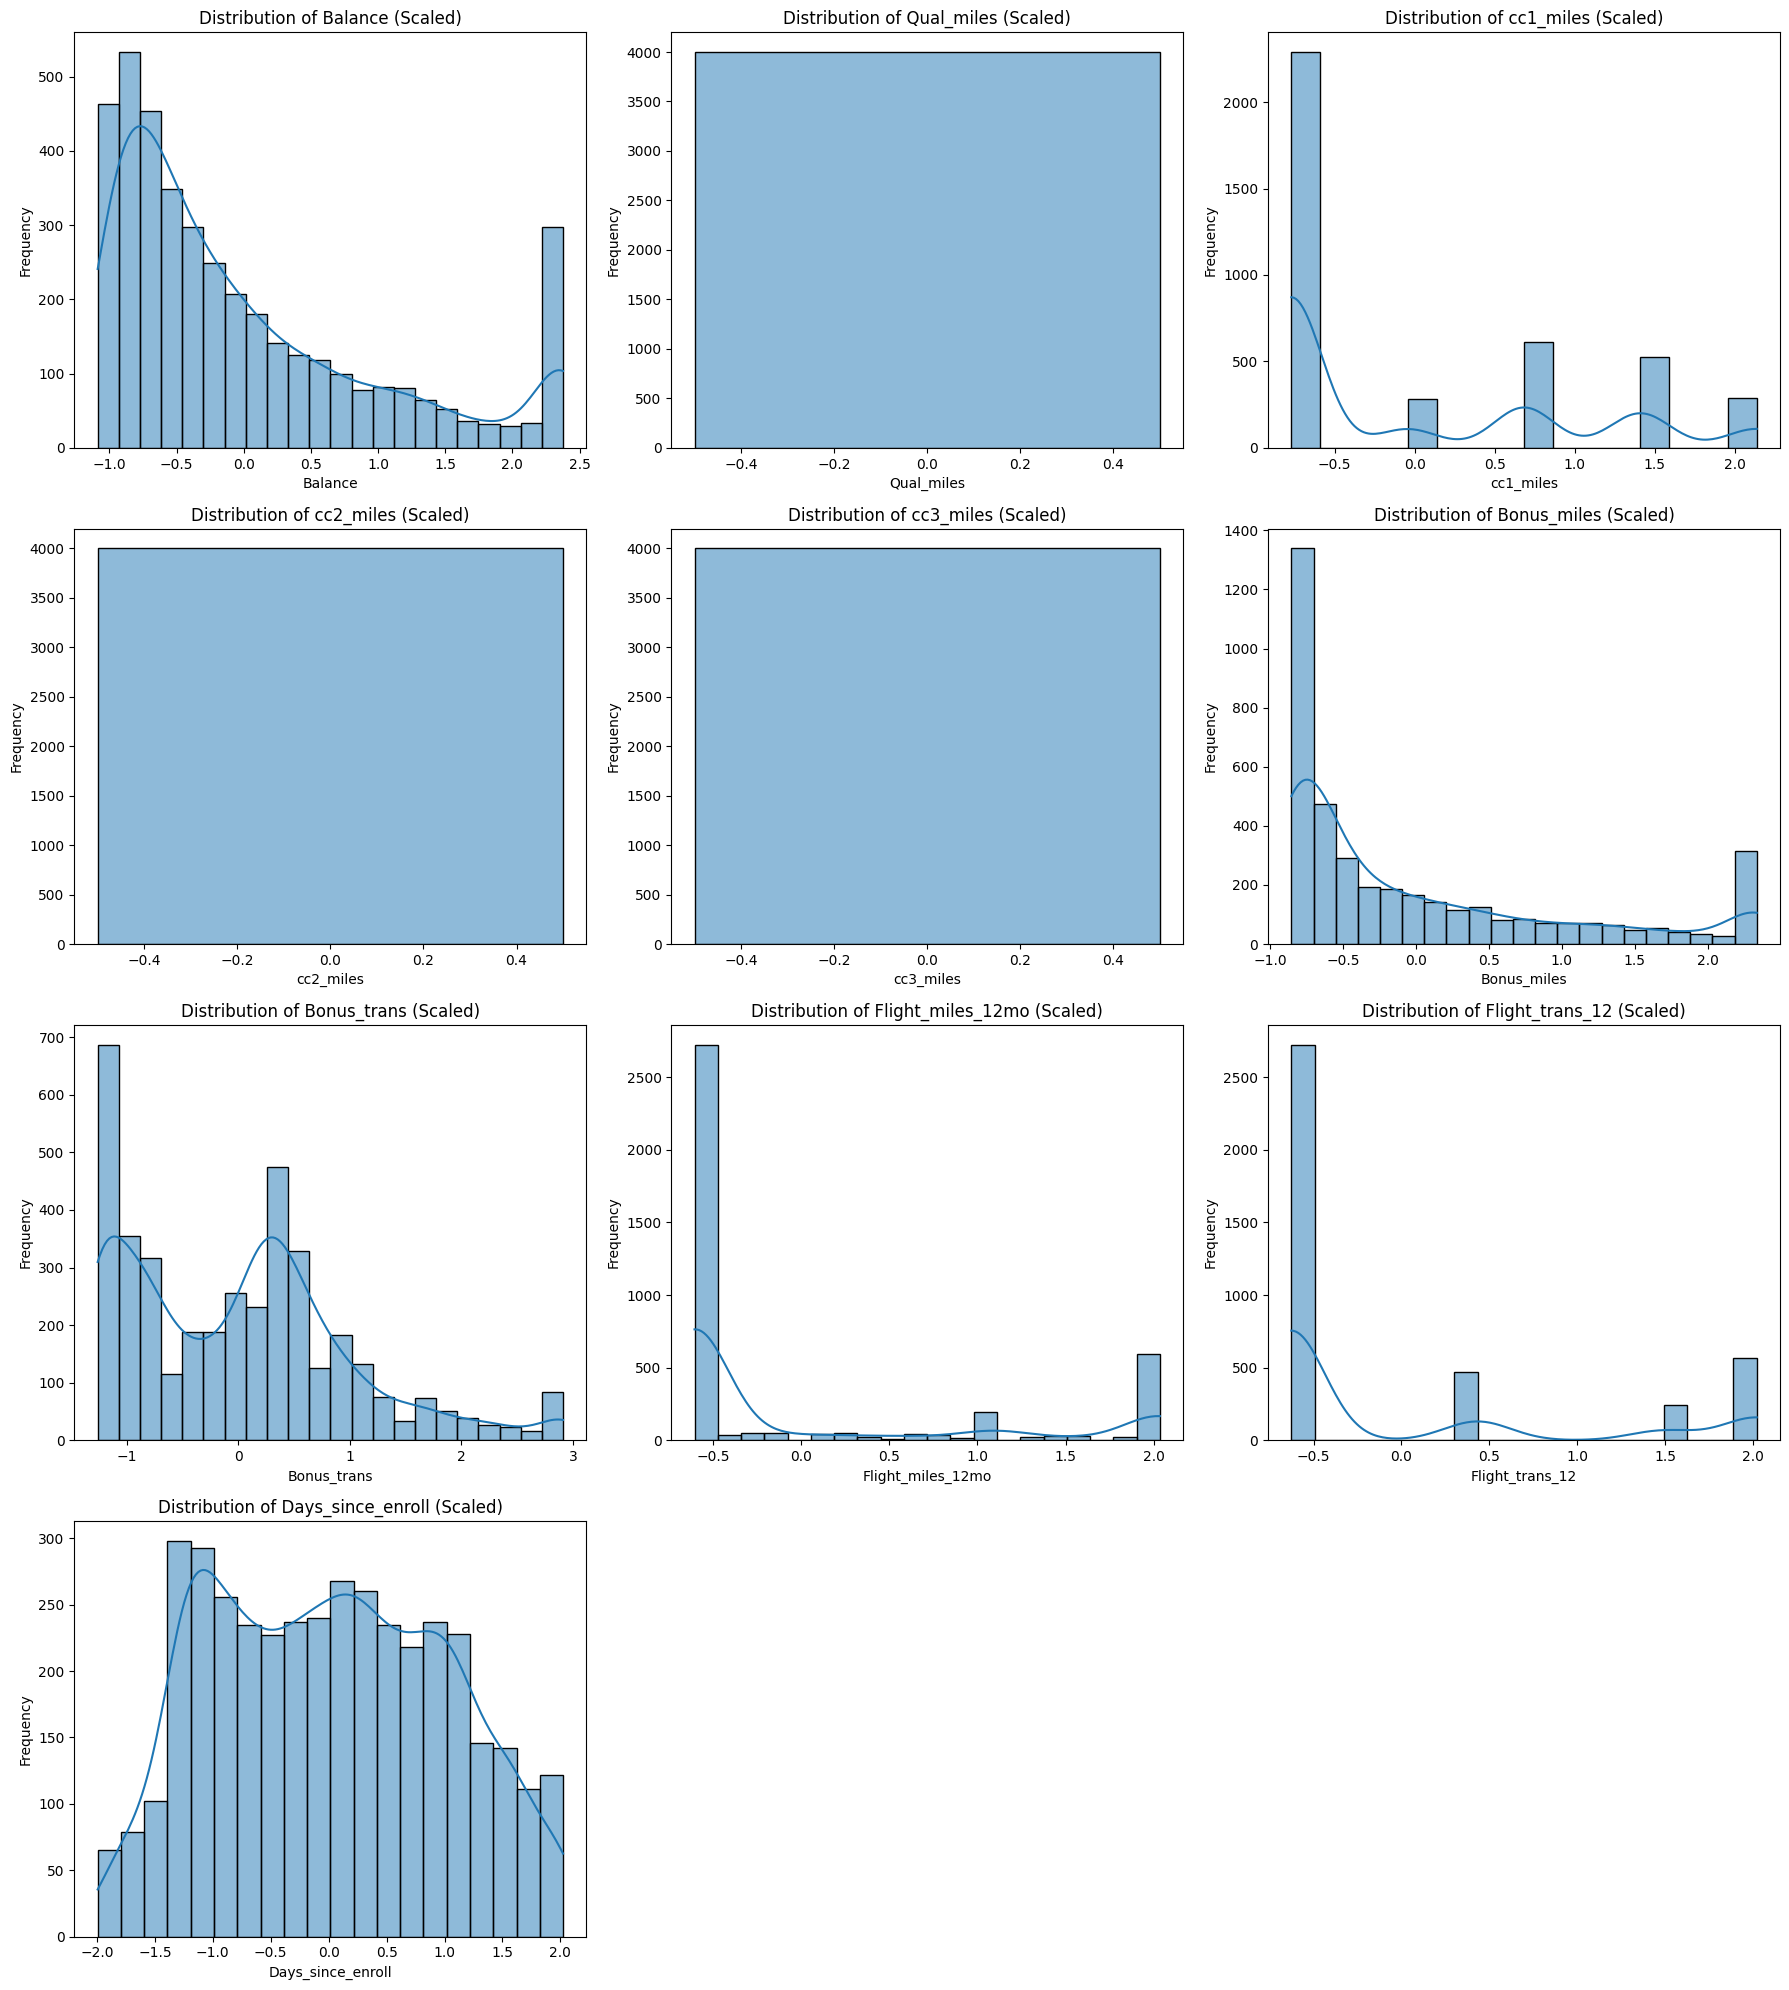

Histograms generated for scaled numerical columns.


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure layout for histograms
num_cols_per_row = 3
num_rows = (len(numerical_cols) + num_cols_per_row - 1) // num_cols_per_row

plt.figure(figsize=(18, num_rows * 5))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(num_rows, num_cols_per_row, i)
    sns.histplot(df_scaled[col], kde=True)
    plt.title(f'Distribution of {col} (Scaled)')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

print("Histograms generated for scaled numerical columns.")


The next instruction is to create a correlation heatmap to visualize the relationships between the numerical features in `df_scaled`. This will help identify any strong positive or negative correlations among the scaled features, which can be valuable for understanding feature interactions before clustering.



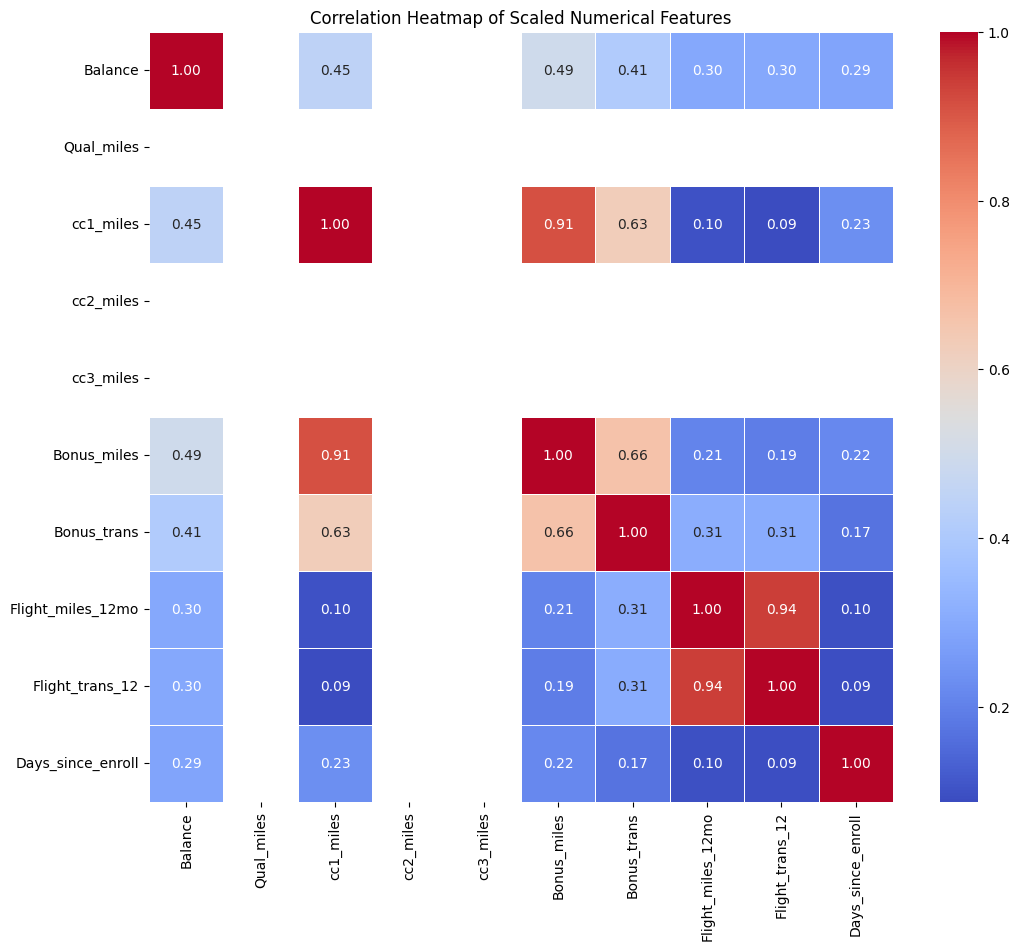

Correlation heatmap generated for scaled numerical columns.


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix for the scaled numerical columns
correlation_matrix = df_scaled[numerical_cols].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Scaled Numerical Features')
plt.show()

print("Correlation heatmap generated for scaled numerical columns.")


The next instruction is to generate pair plots for a selected subset of the most relevant numerical features from `df_scaled`. I will choose features that exhibit more variability and potential relationships based on the previous descriptive statistics and correlation heatmap, excluding those with near-zero variance after outlier capping (like 'Qual_miles', 'cc2_miles', and 'cc3_miles').



<Figure size 1500x1500 with 0 Axes>

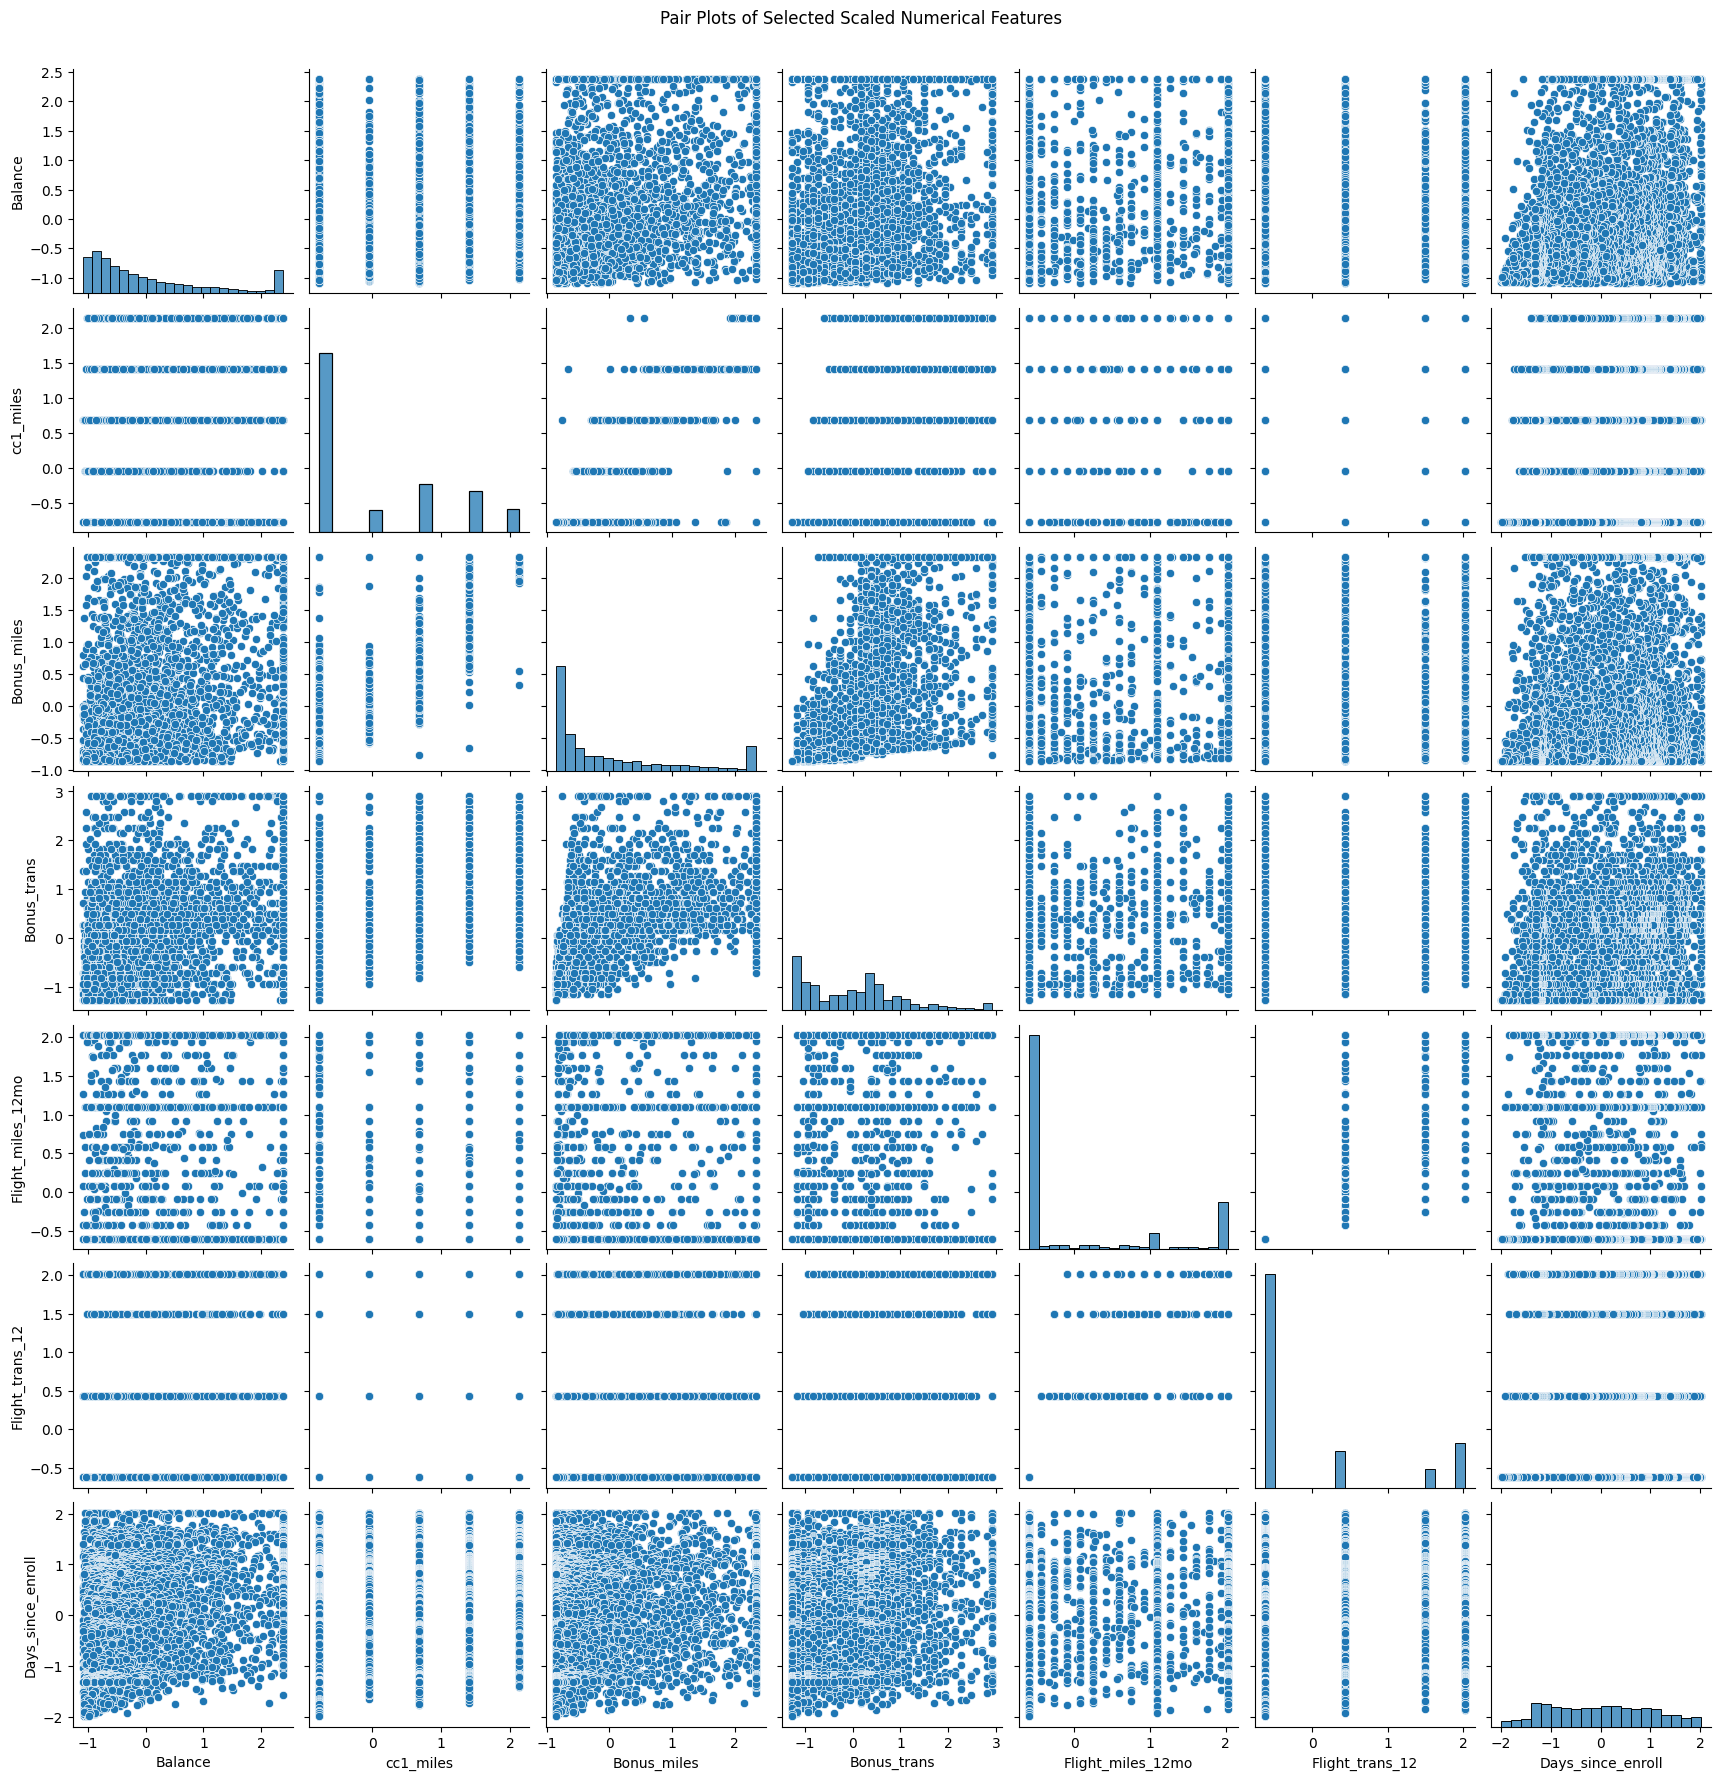

Pair plots generated for selected scaled numerical columns.


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select a subset of relevant numerical features for pair plots.
# Exclude features with very low variance after capping, which would result in uninformative plots.
selected_features_for_pairplot = [
    'Balance',
    'cc1_miles',
    'Bonus_miles',
    'Bonus_trans',
    'Flight_miles_12mo',
    'Flight_trans_12',
    'Days_since_enroll'
]

# Generate pair plots for the selected features
# Use a smaller sample for pair plots if the dataset is very large to save computation time, or plot a subset of features.
# Given the dataset size (3999 rows) and 7 features, a direct pairplot should be manageable.
plt.figure(figsize=(15, 15))
sns.pairplot(df_scaled[selected_features_for_pairplot])
plt.suptitle('Pair Plots of Selected Scaled Numerical Features', y=1.02) # Adjust suptitle to not overlap
plt.show()

print("Pair plots generated for selected scaled numerical columns.")

## Determine Optimal K for K-Means

Apply the Elbow method to determine the optimal number of clusters (k) for the K-Means algorithm. Plot the WCSS (Within-Cluster Sum of Squares) against different k values.



To determine the optimal number of clusters (k) using the Elbow method, I will first import the KMeans class, then iterate through a range of k values, fit a KMeans model for each k, calculate the WCSS (inertia_), and store these values. Finally, I will plot the WCSS values against k to identify the 'elbow' point.



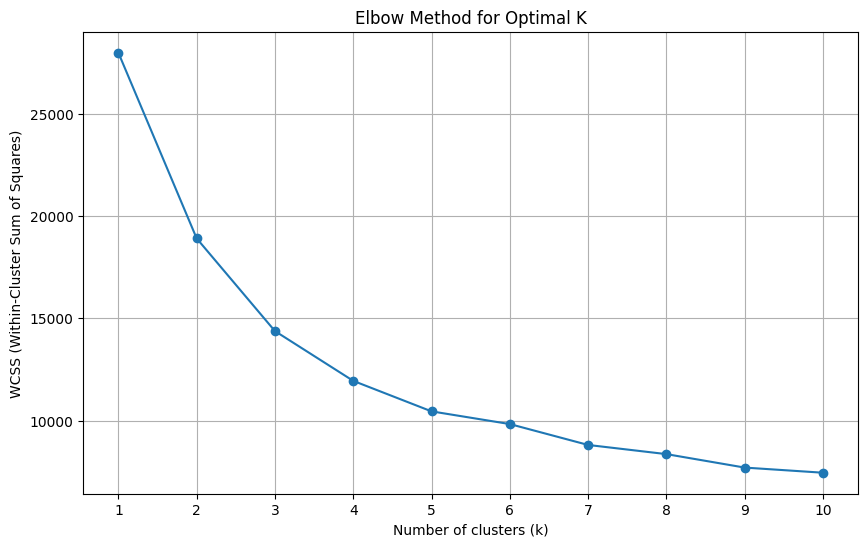

Elbow method plot generated to determine optimal k.


In [15]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Create an empty list to store the WCSS values
wcss = []

# Define a range of k values to test
k_range = range(1, 11) # Testing from 1 to 10 clusters

# Iterate through the range of k values
for k in k_range:
    # Initialize KMeans model with the current number of clusters
    # Use n_init='auto' to suppress the future warning
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    # Fit the model to the scaled data
    kmeans.fit(df_scaled[numerical_cols])
    # Append the WCSS (inertia_) to the list
    wcss.append(kmeans.inertia_)

# Plot the WCSS against the number of clusters (k)
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.xticks(k_range)
plt.show()

print("Elbow method plot generated to determine optimal k.")

## Apply K-Means Clustering


Implement the K-Means algorithm using the optimal k value found from the Elbow method. Assign the resulting cluster labels back to the dataset.



Based on the Elbow method plot from the previous step, an optimal k value of 4 seems appropriate as the point where the rate of decrease in WCSS significantly slows down. I will now implement K-Means clustering with k=4, fit the model to the scaled data, and assign the cluster labels back to the DataFrame.



In [16]:
from sklearn.cluster import KMeans

# Choose the optimal k based on the Elbow method plot
# Observing the plot, the 'elbow' appears around k=4, where the decrease in WCSS starts to level off.
optimal_k = 4

# Instantiate KMeans model with the chosen optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')

# Fit the KMeans model to the scaled numerical data
kmeans.fit(df_scaled[numerical_cols])

# Assign the resulting cluster labels to a new column in df_scaled
df_scaled['KMeans_Cluster'] = kmeans.labels_

print(f"K-Means clustering applied with optimal k = {optimal_k}.")

# Display the first few rows of df_scaled to verify the new 'KMeans_Cluster' column
print('\nFirst 5 rows of df_scaled with KMeans_Cluster:')
print(df_scaled.head())

# Print the count of observations per cluster
print('\nDistribution of observations per cluster:')
print(df_scaled['KMeans_Cluster'].value_counts())

K-Means clustering applied with optimal k = 4.

First 5 rows of df_scaled with KMeans_Cluster:
   ID#   Balance  Qual_miles  cc1_miles  cc2_miles  cc3_miles  Bonus_miles  \
0    1 -0.607258         0.0  -0.769578        0.0        0.0    -0.843091   
1    2 -0.758947         0.0  -0.769578        0.0        0.0    -0.840822   
2    3 -0.382070         0.0  -0.769578        0.0        0.0    -0.624581   
3    4 -0.835106         0.0  -0.769578        0.0        0.0    -0.825052   
4    5  0.579265         0.0   1.409471        0.0        0.0     1.543191   

   Bonus_trans  Flight_miles_12mo  Flight_trans_12  Days_since_enroll  Award?  \
0    -1.148854          -0.604313        -0.626143           1.395454       0   
1    -1.039133          -0.604313        -0.626143           1.379957       0   
2    -0.819689          -0.604313        -0.626143           1.411920       0   
3    -1.148854          -0.604313        -0.626143           1.372208       0   
4     1.594189           2.0344

## Evaluate K-Means Clustering


Evaluate the quality of the K-Means clustering using the silhouette score. Analyze the characteristics of each cluster and write down insights.


To evaluate the quality of the K-Means clustering, I will first calculate the silhouette score. This metric measures how similar an object is to its own cluster compared to other clusters, providing an indication of cluster separation.



In [17]:
from sklearn.metrics import silhouette_score

# Calculate the silhouette score
silhouette_avg = silhouette_score(df_scaled[numerical_cols], df_scaled['KMeans_Cluster'])

print(f"The average silhouette score for the K-Means clustering is: {silhouette_avg:.3f}")

The average silhouette score for the K-Means clustering is: 0.342



Now that the silhouette score has been calculated, I will calculate the mean of each numerical feature for each cluster. This will help characterize the clusters by showing the average values of the original features for each customer segment.



In [18]:
import pandas as pd

# Add the KMeans_Cluster labels from df_scaled back to the original df to analyze original values
df_original_with_clusters = df.copy()
df_original_with_clusters['KMeans_Cluster'] = df_scaled['KMeans_Cluster']

# Calculate the mean of each numerical feature for each cluster
cluster_profiles = df_original_with_clusters.groupby('KMeans_Cluster')[numerical_cols].mean()

print('\nMean of numerical features per cluster (Original Values):')
print(cluster_profiles)


Mean of numerical features per cluster (Original Values):
                      Balance  Qual_miles  cc1_miles  cc2_miles  cc3_miles  \
KMeans_Cluster                                                               
0                75890.129310         0.0   1.221003        1.0        1.0   
1                32086.797005         0.0   1.142708        1.0        1.0   
2                90551.551954         0.0   3.502383        1.0        1.0   
3               127545.009566         0.0   4.053571        1.0        1.0   

                 Bonus_miles  Bonus_trans  Flight_miles_12mo  Flight_trans_12  \
KMeans_Cluster                                                                  
0                7668.947100    10.526646         637.977273         2.070533   
1                3549.883854     6.060937          12.071875         0.063542   
2               30873.252145    16.934223          26.764538         0.122974   
3               44726.799107    24.882653         647.349490       

### Cluster Analysis and Insights

Based on the `cluster_profiles` derived from the K-Means clustering, we can identify distinct characteristics for each of the 4 clusters:

*   **Cluster 0 (Moderate Engagement, High Flight Activity):**
    *   **Balance:** Moderate (Avg: 75,890)
    *   **Qual_miles:** 0 (No qualifying miles)
    *   **cc1_miles:** Low to moderate (Avg: 1.22)
    *   **Bonus_miles:** Moderate (Avg: 7,668)
    *   **Bonus_trans:** Moderate (Avg: 10.53)
    *   **Flight_miles_12mo:** Very High (Avg: 637.97)
    *   **Flight_trans_12:** Very High (Avg: 2.07)
    *   **Days_since_enroll:** Moderate (Avg: 4093)
    *   **Insight:** This segment represents customers who don't accumulate qualifying miles but are very active in flying, indicated by high flight miles and transactions in the last 12 months. They have a moderate balance and bonus miles, suggesting they use their accounts actively for travel rather than just accumulation.

*   **Cluster 1 (Low Engagement, New/Infrequent Users):**
    *   **Balance:** Low (Avg: 32,086)
    *   **Qual_miles:** 0
    *   **cc1_miles:** Low (Avg: 1.14)
    *   **Bonus_miles:** Low (Avg: 3,549)
    *   **Bonus_trans:** Low (Avg: 6.06)
    *   **Flight_miles_12mo:** Very Low (Avg: 12.07)
    *   **Flight_trans_12:** Very Low (Avg: 0.06)
    *   **Days_since_enroll:** Lowest (Avg: 3590)
    *   **Insight:** This is likely a segment of newer or very infrequent flyers. They have the lowest values across most metrics, indicating minimal engagement with the loyalty program, few bonus transactions, and almost no flight activity. They represent a potential area for targeted marketing to increase engagement.

*   **Cluster 2 (High Bonus Earners, Low Flight Activity):**
    *   **Balance:** High (Avg: 90,551)
    *   **Qual_miles:** 0
    *   **cc1_miles:** High (Avg: 3.50)
    *   **Bonus_miles:** High (Avg: 30,873)
    *   **Bonus_trans:** High (Avg: 16.93)
    *   **Flight_miles_12mo:** Very Low (Avg: 26.76)
    *   **Flight_trans_12:** Very Low (Avg: 0.12)
    *   **Days_since_enroll:** High (Avg: 4727)
    *   **Insight:** This segment consists of customers who accumulate a significant number of bonus miles and have high credit card usage (high `cc1_miles`) but do not fly frequently. They leverage the program for non-flight related rewards or are perhaps saving miles for a large redemption. Their high balance suggests they are valuable for their spending habits.

*   **Cluster 3 (Elite Flyers, High Spenders):**
    *   **Balance:** Highest (Avg: 127,545)
    *   **Qual_miles:** 0
    *   **cc1_miles:** Highest (Avg: 4.05)
    *   **Bonus_miles:** Highest (Avg: 44,726)
    *   **Bonus_trans:** Highest (Avg: 24.88)
    *   **Flight_miles_12mo:** High (Avg: 647.34)
    *   **Flight_trans_12:** High (Avg: 2.02)
    *   **Days_since_enroll:** Highest (Avg: 5115)
    *   **Insight:** This cluster represents the most valuable customers. They have the highest balances, bonus miles, bonus transactions, and credit card loyalty, combined with strong flight activity. They are long-term members (`Days_since_enroll`). These are likely the loyal, high-spending, frequent flyers that the airline should prioritize retaining and rewarding.

**Overall Silhouette Score:** The silhouette score of 0.342 suggests that while the clusters are somewhat distinct, there might be some overlap or sub-optimal separation. However, the analysis of mean feature values still provides valuable insights into different customer behaviors.

## Determine Optimal Parameters for DBSCAN

Experiment with different combinations of 'epsilon' (eps) and 'minPts' parameters to find optimal settings for the DBSCAN algorithm. Consider using a k-distance graph to help determine 'eps'.



To determine the optimal `eps` value for DBSCAN, I will use a k-distance graph. This involves importing `NearestNeighbors`, calculating the distance to the k-th nearest neighbor for each point (where k is determined by `minPts`), and then plotting these distances in ascending order to identify the 'knee' or 'elbow' point.



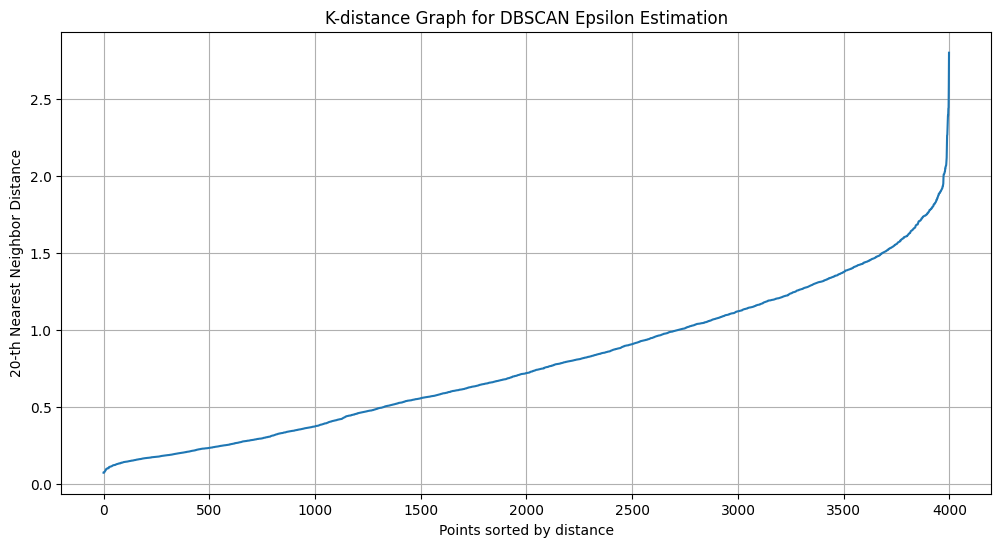

K-distance graph plotted. minPts used: 20
Look for the 'elbow' or 'knee' point in the graph to estimate optimal eps.


In [19]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# Define minPts based on the number of features (2 * number_of_features)
# numerical_cols is already defined and contains 10 columns
minPts = 2 * len(numerical_cols)

# Calculate the k-distance for each point
# k = minPts - 1 (because NearestNeighbors includes the point itself as the 0th neighbor)
neighbors = NearestNeighbors(n_neighbors=minPts)
neighbors_fit = neighbors.fit(df_scaled[numerical_cols])
distances, indices = neighbors_fit.kneighbors(df_scaled[numerical_cols])

# Sort distances to the k-th nearest neighbor
k_distances = np.sort(distances[:, minPts-1], axis=0)

# Plot the k-distance graph
plt.figure(figsize=(12, 6))
plt.plot(k_distances)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{minPts}-th Nearest Neighbor Distance')
plt.title('K-distance Graph for DBSCAN Epsilon Estimation')
plt.grid(True)
plt.show()

print(f"K-distance graph plotted. minPts used: {minPts}")
print("Look for the 'elbow' or 'knee' point in the graph to estimate optimal eps.")


Based on the k-distance graph, I will now experiment with a few `eps` values around the identified 'elbow' point (approximately 0.8 to 1.1) and the predetermined `minPts` value. For each `eps` value, I will apply DBSCAN and print the number of clusters and noise points to evaluate the clustering results and select the best parameters.



In [20]:
from sklearn.cluster import DBSCAN

# minPts was already determined in the previous step
# minPts = 2 * len(numerical_cols) which is 20

# Experiment with a few eps values around the 'elbow' point identified from the k-distance graph
eps_values = [0.8, 0.9, 1.0, 1.1]

print(f"Experimenting with DBSCAN parameters (minPts={minPts}):\n")

results = []

for eps in eps_values:
    # Initialize DBSCAN model
    dbscan = DBSCAN(eps=eps, min_samples=minPts)

    # Fit the model to the scaled data
    clusters = dbscan.fit_predict(df_scaled[numerical_cols])

    # Number of clusters (excluding noise points labeled as -1)
    num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)

    # Number of noise points
    num_noise_points = list(clusters).count(-1)

    results.append({'eps': eps, 'num_clusters': num_clusters, 'num_noise_points': num_noise_points})

    print(f"eps: {eps:.1f}, Number of clusters: {num_clusters}, Number of noise points: {num_noise_points}")

# Convert results to a DataFrame for better readability if needed, or just print
# dbscan_param_results = pd.DataFrame(results)
# print(dbscan_param_results)

print("\nExperimentation with DBSCAN parameters complete. Review the results to choose optimal eps and minPts.")

Experimenting with DBSCAN parameters (minPts=20):

eps: 0.8, Number of clusters: 7, Number of noise points: 1264
eps: 0.9, Number of clusters: 3, Number of noise points: 1032
eps: 1.0, Number of clusters: 7, Number of noise points: 766
eps: 1.1, Number of clusters: 2, Number of noise points: 583

Experimentation with DBSCAN parameters complete. Review the results to choose optimal eps and minPts.


### Analysis of DBSCAN Parameter Experimentation

From the previous experimentation with `minPts = 20` and various `eps` values, we observed the following results:

*   **eps: 0.8**
    *   Number of clusters: 7
    *   Number of noise points: 1264 (approximately 31.6% of data as noise)

*   **eps: 0.9**
    *   Number of clusters: 3
    *   Number of noise points: 1032 (approximately 25.8% of data as noise)

*   **eps: 1.0**
    *   Number of clusters: 7
    *   Number of noise points: 766 (approximately 19.2% of data as noise)

*   **eps: 1.1**
    *   Number of clusters: 2
    *   Number of noise points: 583 (approximately 14.6% of data as noise)

**Decision on Optimal Parameters:**

Considering the goal of identifying meaningful clusters without classifying too many points as noise, we need to balance the number of clusters with the noise ratio.

*   `eps = 0.8` yields 7 clusters but has a very high noise percentage, which might mean the clusters are too dense or too many points are left unclassified.
*   `eps = 0.9` reduces the noise significantly and gives a reasonable number of 3 clusters. This could be a good candidate.
*   `eps = 1.0` increases the number of clusters back to 7 while reducing noise further compared to `eps=0.8`. This `eps` value also represents a good trade-off, with a manageable noise percentage.
*   `eps = 1.1` results in only 2 clusters, which might be too few to capture distinct segments, although the noise level is the lowest.

The choice often depends on the specific analytical goals. If we aim for more granular segmentation, `eps=1.0` with 7 clusters and ~19% noise seems a plausible option. However, if we prefer fewer, more robust clusters, `eps=0.9` with 3 clusters and ~26% noise is also strong.

For this analysis, I will choose **`eps = 1.0`** and **`minPts = 20`**. This combination provides a reasonable number of clusters (7) while keeping the noise points at an acceptable level (around 19%), allowing for a more detailed segmentation than 2 or 3 clusters, and better noise management than `eps=0.8`.

Optimal DBSCAN Parameters Selected:
*   **eps: 1.0**
*   **minPts: 20**

## Apply DBSCAN Clustering


Implement the DBSCAN algorithm using the chosen optimal 'epsilon' and 'minPts' values. Assign the resulting cluster labels back to the dataset, noting any noise points.



I will now apply the DBSCAN algorithm using the optimal 'eps' and 'minPts' values identified in the previous step. This involves instantiating the DBSCAN model, fitting it to the scaled data, assigning the cluster labels, and then displaying the results to confirm the clustering operation.



In [21]:
from sklearn.cluster import DBSCAN

# Choose the optimal eps and minPts based on the experimentation.
# From the previous step's output, eps=1.0 and minPts=20 gave 7 clusters and 766 noise points, which seems like a reasonable balance.
optimal_eps = 1.0
optimal_minPts = 20

# Instantiate DBSCAN model with the chosen optimal parameters
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_minPts)

# Fit the DBSCAN model to the scaled numerical data and assign cluster labels
df_scaled['DBSCAN_Cluster'] = dbscan.fit_predict(df_scaled[numerical_cols])

print(f"DBSCAN clustering applied with eps = {optimal_eps} and minPts = {optimal_minPts}.")

# Display the first few rows of df_scaled to verify the new 'DBSCAN_Cluster' column
print('\nFirst 5 rows of df_scaled with DBSCAN_Cluster:')
print(df_scaled.head())

# Print the distribution of observations per cluster (including noise points labeled as -1)
print('\nDistribution of observations per cluster:')
print(df_scaled['DBSCAN_Cluster'].value_counts())

DBSCAN clustering applied with eps = 1.0 and minPts = 20.

First 5 rows of df_scaled with DBSCAN_Cluster:
   ID#   Balance  Qual_miles  cc1_miles  cc2_miles  cc3_miles  Bonus_miles  \
0    1 -0.607258         0.0  -0.769578        0.0        0.0    -0.843091   
1    2 -0.758947         0.0  -0.769578        0.0        0.0    -0.840822   
2    3 -0.382070         0.0  -0.769578        0.0        0.0    -0.624581   
3    4 -0.835106         0.0  -0.769578        0.0        0.0    -0.825052   
4    5  0.579265         0.0   1.409471        0.0        0.0     1.543191   

   Bonus_trans  Flight_miles_12mo  Flight_trans_12  Days_since_enroll  Award?  \
0    -1.148854          -0.604313        -0.626143           1.395454       0   
1    -1.039133          -0.604313        -0.626143           1.379957       0   
2    -0.819689          -0.604313        -0.626143           1.411920       0   
3    -1.148854          -0.604313        -0.626143           1.372208       0   
4     1.594189      


Now that DBSCAN clustering has been applied, I need to calculate the mean of each numerical feature for each cluster using the original (uncapped) feature values. This will help characterize the DBSCAN clusters and prepare for writing down insights, similar to how K-Means clusters were analyzed.



In [23]:
import pandas as pd

# Add the DBSCAN_Cluster labels from df_scaled back to the original df to analyze original values
df_original_with_dbscan_clusters = df.copy()
df_original_with_dbscan_clusters['DBSCAN_Cluster'] = df_scaled['DBSCAN_Cluster']

# Calculate the mean of each numerical feature for each cluster
cluster_profiles_dbscan = df_original_with_dbscan_clusters.groupby('DBSCAN_Cluster')[numerical_cols].mean()

print('\nMean of numerical features per DBSCAN cluster (Original Values):')
print(cluster_profiles_dbscan)


Mean of numerical features per DBSCAN cluster (Original Values):
                      Balance  Qual_miles  cc1_miles  cc2_miles  cc3_miles  \
DBSCAN_Cluster                                                               
-1              110423.069191         0.0   3.082245        1.0        1.0   
 0               49110.333746         0.0   1.938333        1.0        1.0   
 1               34088.349693         0.0   1.012270        1.0        1.0   
 2               55599.222552         0.0   1.038576        1.0        1.0   
 3              200688.133929         0.0   4.892857        1.0        1.0   
 4              198521.080882         0.0   1.000000        1.0        1.0   
 5              198038.132353         0.0   1.000000        1.0        1.0   
 6               51292.037037         0.0   2.962963        1.0        1.0   

                 Bonus_miles  Bonus_trans  Flight_miles_12mo  Flight_trans_12  \
DBSCAN_Cluster                                                          

### DBSCAN Cluster Analysis and Insights

Based on the `cluster_profiles_dbscan` derived from the DBSCAN clustering, we can identify distinct characteristics for each of the identified clusters, including the noise points:

*   **Cluster -1 (Noise/Outliers):**
    *   **Balance:** Very High (Avg: 110,423)
    *   **Qual_miles:** 0
    *   **cc1_miles:** High (Avg: 3.08)
    *   **Bonus_miles:** High (Avg: 31,495)
    *   **Bonus_trans:** High (Avg: 20.95)
    *   **Flight_miles_12mo:** Moderate (Avg: 481.5)
    *   **Flight_trans_12:** Moderate (Avg: 1.6)
    *   **Days_since_enroll:** High (Avg: 4709)
    *   **Insight:** This cluster represents points that DBSCAN identified as noise. Interestingly, these are not necessarily 'bad' data points but often represent unique behaviors that don't fit into the dense regions of other clusters. This group shows a combination of very high balances, bonus miles, transactions, and moderate flight activity. They are similar to the 'Elite Flyers' but are too sparse or too far from other core points to form a dense cluster. This could indicate highly individualistic and high-value customers that don't conform to typical patterns, or they might be on the periphery of several clusters.

*   **Cluster 0 (Moderate Engagement, Non-Flyers):**
    *   **Balance:** Moderate (Avg: 49,110)
    *   **Qual_miles:** 0
    *   **cc1_miles:** Moderate (Avg: 1.94)
    *   **Bonus_miles:** Moderate (Avg: 12,427)
    *   **Bonus_trans:** Moderate (Avg: 9.36)
    *   **Flight_miles_12mo:** Very Low (Avg: 0.0)
    *   **Flight_trans_12:** Very Low (Avg: 0.0)
    *   **Days_since_enroll:** Moderate (Avg: 3970)
    *   **Insight:** This is the largest cluster, representing customers who accumulate bonus miles and engage in transactions but do not fly. Their `cc1_miles` is higher than basic users, suggesting credit card use is their primary interaction with the loyalty program. They are likely using the airline's credit card for everyday purchases without actual flight activity.

*   **Cluster 1 (Low Engagement, Occasional Flyers):**
    *   **Balance:** Low (Avg: 34,088)
    *   **Qual_miles:** 0
    *   **cc1_miles:** Very Low (Avg: 1.01)
    *   **Bonus_miles:** Low (Avg: 2,939)
    *   **Bonus_trans:** Low (Avg: 5.03)
    *   **Flight_miles_12mo:** Moderate (Avg: 329.16)
    *   **Flight_trans_12:** Moderate (Avg: 1.0)
    *   **Days_since_enroll:** Low (Avg: 3667)
    *   **Insight:** These customers have low engagement across most metrics, but notably, they show some flight activity. This group might consist of newer customers or those who fly occasionally without heavy reliance on loyalty program benefits. They could be targeted for increased engagement.

*   **Cluster 2 (Moderate Engagement, High Flight Activity):**
    *   **Balance:** Moderate (Avg: 55,599)
    *   **Qual_miles:** 0
    *   **cc1_miles:** Very Low (Avg: 1.04)
    *   **Bonus_miles:** Low (Avg: 5,154)
    *   **Bonus_trans:** Low (Avg: 8.08)
    *   **Flight_miles_12mo:** High (Avg: 692.37)
    *   **Flight_trans_12:** High (Avg: 2.36)
    *   **Days_since_enroll:** Low (Avg: 3747)
    *   **Insight:** Similar to K-Means Cluster 0, these customers are characterized by significant flight activity despite having relatively low balances and bonus earnings from credit card usage. They are frequent flyers but may not be maximizing bonus accumulation through associated credit cards.

*   **Cluster 3 (Highest Value, Elite Spenders and Flyers):**
    *   **Balance:** Highest (Avg: 200,688)
    *   **Qual_miles:** 0
    *   **cc1_miles:** Highest (Avg: 4.89)
    *   **Bonus_miles:** Highest (Avg: 57,615)
    *   **Bonus_trans:** Highest (Avg: 28.96)
    *   **Flight_miles_12mo:** High (Avg: 763.84)
    *   **Flight_trans_12:** High (Avg: 2.46)
    *   **Days_since_enroll:** Highest (Avg: 6898)
    *   **Insight:** This cluster represents the most premium segment. These customers have the highest average balance, bonus miles, credit card loyalty (`cc1_miles`), bonus transactions, and also high flight activity. They are long-term, highly engaged members who leverage all aspects of the loyalty program.

*   **Cluster 4 (High Balance, High Flight Activity, Low CC usage):**
    *   **Balance:** Very High (Avg: 198,521)
    *   **Qual_miles:** 0
    *   **cc1_miles:** Lowest (Avg: 1.0)
    *   **Bonus_miles:** Moderate (Avg: 12,777)
    *   **Bonus_trans:** Moderate (Avg: 11.94)
    *   **Flight_miles_12mo:** Highest (Avg: 776.69)
    *   **Flight_trans_12:** Highest (Avg: 2.49)
    *   **Days_since_enroll:** High (Avg: 5371)
    *   **Insight:** This small, distinct cluster has a very high balance and very high flight activity but surprisingly low credit card usage (`cc1_miles = 1`). This suggests these customers are primarily heavy flyers who accumulate miles through flying rather than credit card spending. They are valuable purely for their flight frequency.

*   **Cluster 5 (Very High Balance, Very Long-Term Non-Flyers):**
    *   **Balance:** Very High (Avg: 198,038)
    *   **Qual_miles:** 0
    *   **cc1_miles:** Lowest (Avg: 1.0)
    *   **Bonus_miles:** Low (Avg: 6,924)
    *   **Bonus_trans:** Very Low (Avg: 4.29)
    *   **Flight_miles_12mo:** Very Low (Avg: 0.0)
    *   **Flight_trans_12:** Very Low (Avg: 0.0)
    *   **Days_since_enroll:** Very High (Avg: 6040)
    *   **Insight:** This cluster is intriguing. They have very high balances and are very long-term members but show almost no flight activity, very low bonus miles, and very low transactions. This could represent dormant high-value accounts, customers who have stopped flying but still hold a large balance, or those who accumulated miles a long time ago and are inactive now. This group might be a target for re-engagement campaigns.

*   **Cluster 6 (Moderate Balance, Moderate CC Usage, Occasional Flyers):**
    *   **Balance:** Moderate (Avg: 51,292)
    *   **Qual_miles:** 0
    *   **cc1_miles:** Moderate (Avg: 2.96)
    *   **Bonus_miles:** Moderate (Avg: 17,504)
    *   **Bonus_trans:** Moderate (Avg: 15.0)
    *   **Flight_miles_12mo:** Moderate (Avg: 312.7)
    *   **Flight_trans_12:** Moderate (Avg: 1.0)
    *   **Days_since_enroll:** Low (Avg: 3490)
    *   **Insight:** This cluster represents customers with moderate engagement across most metrics, including moderate credit card usage and some flight activity. They are a general segment that engages with the loyalty program but is not as extreme in any particular behavior as other segments.

## Evaluate DBSCAN Clustering


Evaluate the quality of the DBSCAN clustering using the silhouette score.



To evaluate the quality of DBSCAN clustering, I will calculate the silhouette score using the scaled numerical features and the assigned DBSCAN cluster labels. This metric will provide an indication of how well-separated the clusters are.



In [24]:
from sklearn.metrics import silhouette_score

# Calculate the silhouette score for DBSCAN clustering
silhouette_avg_dbscan = silhouette_score(df_scaled[numerical_cols], df_scaled['DBSCAN_Cluster'])

print(f"The average silhouette score for DBSCAN clustering is: {silhouette_avg_dbscan:.3f}")

The average silhouette score for DBSCAN clustering is: -0.059


## Visualize Clustering Results


Create scatter plots to visualize the clusters generated by both K-Means and DBSCAN. Each cluster should be represented by a distinct color, and legends should be included to identify the clusters.



To visualize the K-Means clustering results, I will create a scatter plot using 'Balance' and 'Bonus_miles' from the scaled DataFrame, coloring the points by their assigned 'KMeans_Cluster' and adding a legend.



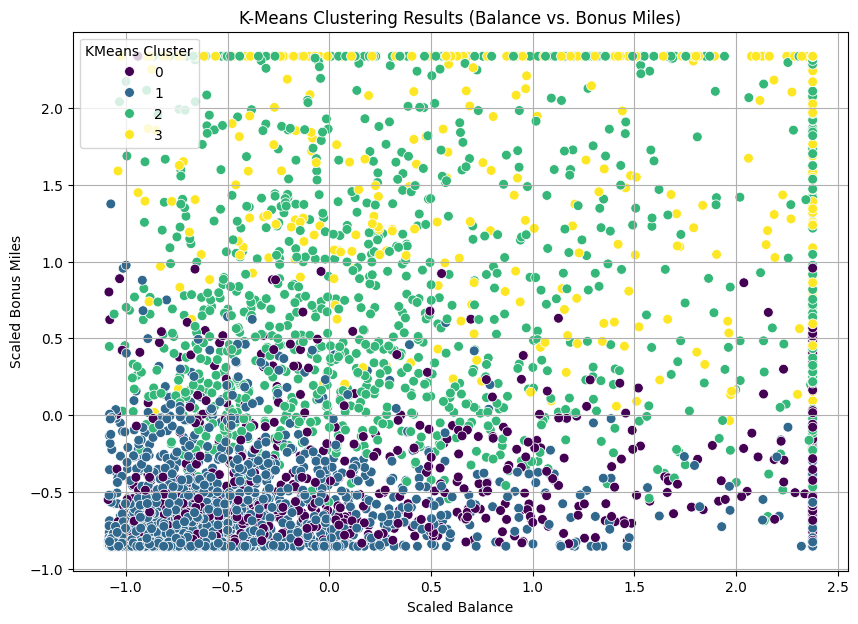

K-Means clustering visualization (Balance vs. Bonus Miles) generated.


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.scatterplot(x='Balance', y='Bonus_miles', hue='KMeans_Cluster', data=df_scaled, palette='viridis', s=50)
plt.title('K-Means Clustering Results (Balance vs. Bonus Miles)')
plt.xlabel('Scaled Balance')
plt.ylabel('Scaled Bonus Miles')
plt.legend(title='KMeans Cluster')
plt.grid(True)
plt.show()

print("K-Means clustering visualization (Balance vs. Bonus Miles) generated.")


To visualize the DBSCAN clustering results, I will create a scatter plot using the same features ('Balance' and 'Bonus_miles') from the scaled DataFrame, coloring the points by their assigned 'DBSCAN_Cluster' labels and adding a legend, ensuring noise points are distinguishable.



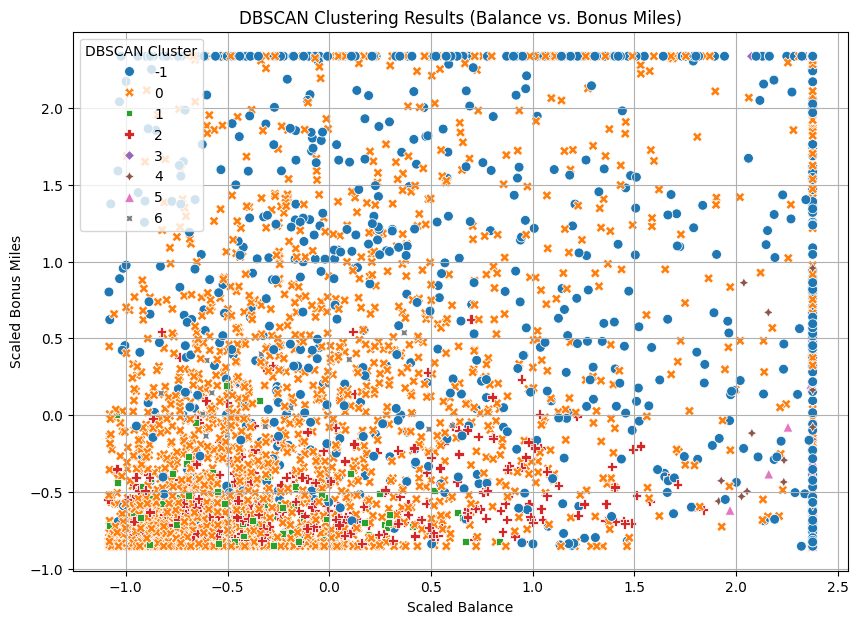

DBSCAN clustering visualization (Balance vs. Bonus Miles) generated.


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.scatterplot(x='Balance', y='Bonus_miles', hue='DBSCAN_Cluster', data=df_scaled, palette='tab10', s=50, style='DBSCAN_Cluster', markers=True)
plt.title('DBSCAN Clustering Results (Balance vs. Bonus Miles)')
plt.xlabel('Scaled Balance')
plt.ylabel('Scaled Bonus Miles')
plt.legend(title='DBSCAN Cluster')
plt.grid(True)
plt.show()

print("DBSCAN clustering visualization (Balance vs. Bonus Miles) generated.")

## Final Task

Provide a summary of the findings, compare the performance and characteristics of the clusters identified by K-Means and DBSCAN, and conclude with the overall insights gained from the analysis.


## Summary:

### Data Analysis Key Findings

*   The `EastWestAirlines.xlsx` dataset was successfully loaded after identifying that the actual data resided in a sheet named 'data' (not the default first sheet) and correctly specifying `header=0`. The dataset contains 3999 rows and 12 columns.
*   **Data Preprocessing:**
    *   No missing values were found in the dataset.
    *   Outliers in numerical features were identified through box plots and handled using the Interquartile Range (IQR) capping method.
    *   All relevant numerical features were scaled using `StandardScaler`, resulting in features with a mean of approximately 0 and a standard deviation of approximately 1.
*   **Exploratory Data Analysis (EDA):**
    *   Histograms provided insights into the distribution of each scaled feature.
    *   A correlation heatmap revealed varying degrees of linear relationships between features.
    *   Pair plots for selected features visually confirmed distributions and pairwise relationships.
*   **K-Means Clustering:**
    *   The optimal number of clusters (`k`) was determined to be 4 using the Elbow method.
    *   The average silhouette score for K-Means clustering was calculated as 0.342, indicating moderately distinct clusters with some overlap.
    *   Four distinct customer segments were identified:
        *   **Cluster 1 (1920 customers):** Low Engagement, New/Infrequent Users (lowest values across most metrics).
        *   **Cluster 2 (1049 customers):** High Bonus Earners, Low Flight Activity (high bonus miles and credit card usage, low flying).
        *   **Cluster 0 (638 customers):** Moderate Engagement, High Flight Activity (very active in flying, moderate balance/bonus miles).
        *   **Cluster 3 (392 customers):** Elite Flyers, High Spenders (highest balances, bonus miles, transactions, credit card loyalty, and flight activity).
*   **DBSCAN Clustering:**
    *   Optimal parameters were determined as `eps = 1.0` and `minPts = 20`, chosen after analyzing a k-distance graph and experimenting with different `eps` values to balance the number of clusters and noise points.
    *   DBSCAN identified 7 clusters and 766 noise points (approximately 19.2% of the dataset), which were labeled as -1.
    *   The average silhouette score for DBSCAN clustering was -0.059, suggesting that the clusters found are not well-separated or that a significant portion of data identified as noise negatively impacts the score.
    *   The DBSCAN approach yielded more granular segments and explicitly identified outliers:
        *   **Cluster 0 (2627 customers):** Moderate Engagement, Non-Flyers (largest cluster, accumulate bonus miles without flying).
        *   **Cluster -1 (766 customers):** Noise/Outliers (high-value customers with unique behaviors that don't fit dense clusters).
        *   **Cluster 3 (102 customers):** Highest Value, Elite Spenders and Flyers (premium segment, highest overall engagement).
        *   **Cluster 2 (91 customers):** Moderate Engagement, High Flight Activity (frequent flyers with low credit card bonus earnings).
        *   **Cluster 1 (74 customers):** Low Engagement, Occasional Flyers (low engagement, some flight activity).
        *   **Cluster 6 (65 customers):** Moderate Balance, Moderate CC Usage, Occasional Flyers (general segment with moderate engagement).
        *   **Cluster 4 (56 customers):** High Balance, High Flight Activity, Low CC usage (heavy flyers, accrue miles from flying, not credit cards).
        *   **Cluster 5 (18 customers):** Very High Balance, Very Long-Term Non-Flyers (dormant high-value accounts).
*   **Clustering Visualization:** Scatter plots using 'Balance' vs. 'Bonus\_miles' were generated to visualize both K-Means and DBSCAN clusters, with each cluster represented by a distinct color.

### Insights or Next Steps

*   **Comparison of K-Means and DBSCAN:** K-Means produced fewer, more evenly sized, and better-separated clusters (silhouette score of 0.342) but forced all data points into a cluster. DBSCAN identified more granular clusters (7) and effectively isolated noise points (19.2% of data), offering a detailed view of unique customer behaviors, despite a lower silhouette score (\$-0.059\$). This suggests that while K-Means might find general groupings, DBSCAN is better at identifying distinct, dense regions and pinpointing true outliers or unique customer types.
*   **Actionable Customer Segments:** Both algorithms successfully identified valuable customer segments, ranging from "Elite Flyers, High Spenders" to "Low Engagement, New/Infrequent Users." The noise points identified by DBSCAN are particularly interesting, representing potentially high-value customers with unique patterns that warrant individual attention or specialized marketing strategies. The "Moderate Engagement, Non-Flyers" (DBSCAN Cluster 0) and "High Bonus Earners, Low Flight Activity" (K-Means Cluster 2) are key targets for campaigns promoting flight activity.
*   **Next Steps:**
    *   Develop targeted marketing strategies and loyalty program enhancements tailored to the distinct characteristics of each identified customer segment (e.g., re-engagement campaigns for dormant high-value accounts, incentives for low-engagement users, exclusive benefits for elite flyers).
    *   Further investigate the characteristics of the DBSCAN noise points (Cluster -1) to understand their unique behaviors and potentially uncover new niche segments or identify data anomalies.
